In [17]:
from operator import mod
from pandas.core.algorithms import mode
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# 数据集合目标函数值赋值，其中dateset为数据，look_back为以几行数据为特征数目
def createDataset(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:i + look_back])
        dataY.append(dataset[i + look_back])
    dataX = torch.tensor(dataX)
    dataX = dataX.reshape(-1, 1, look_back)
    dataY = torch.tensor(dataY)
    dataY = dataY.reshape(-1, 1, 1)
    return dataX, dataY

# 划分训练集和测试集
# 由于是时间序列数据，不适合这样随机打乱
def splitData(data, rate=0.7):
    # 默认训练集比例为0.7
    dataX, dataY = data
    nSample = dataX.shape[0]
    nTrain = int(nSample * rate)
    # shuffledIndices = torch.randperm(nSample)
    trainData = (dataX[:nTrain], dataY[:nTrain])
    testData = (dataX[nTrain:], dataY[nTrain:])
    return trainData, testData

# 定义模型
class LstmModel(nn.Module):
    def __init__(self, inputSize=5, hiddenSize=6):
        super().__init__()
        # LSTM层-> 两个LSTM单元叠加
        self.lstm = nn.LSTM(input_size=inputSize, \
                            hidden_size=hiddenSize, num_layers=2)
        self.output = nn.Linear(6, 1)  # 线性输出

    def forward(self, x):
        # x: input->(time_step, batch, input_size)
        x1, _ = self.lstm(x)
        # x1: output->(time_step, batch, output_size)
        a, b, c = x1.shape
        out = self.output(x1.view(-1, c))  # 只有三维数据转化为二维才能作为输入
        # 重新将结果转化为三维
        out = out.view(a, b, -1)
        return out

# 训练模型
def training_loop(nEpochs, model, optimizer, lossFn, trainData, testData=None):
    trainX, trainY = trainData
    if testData is not None:
        testX, testY = testData
    for epoch in range(1, nEpochs + 1):
        optimizer.zero_grad()  # 梯度清0
        trainP = model(trainX)
        loss = lossFn(trainP, trainY)
        loss.backward()  # 反向传播
        optimizer.step()
        loss_.append(loss.item())

           # 计算 预测的acc
        trainP_ = trainP.view(-1, 2)
        trainY_ = trainY.view(-1, 2)
        _, trainP_ = torch.max(trainP_, 1)
        _, trainY_ = torch.max(trainY_, 1)
        acc = torch.sum(trainP_ == trainY_).item() / len(trainY)
        acc_.append(acc)

        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")
    return model

In [19]:
import math
# 加载飞行数据
flight_data = pd.read_csv('../data/source_data.csv')
# 数据归一化
maxPassenger = flight_data['Number of  reported results'].max()
minPassenger = flight_data['Number of  reported results'].min()
flight_data['Number of  reported results'] = (flight_data['Number of  reported results'] - minPassenger) / (maxPassenger - minPassenger)

dataset = flight_data['Number of  reported results'].values.tolist()
for i in range(len(dataset), len(dataset) + 65):
    temp_data = float((250403*math.exp(-0.008*i) - minPassenger) / (maxPassenger - minPassenger))
    dataset.append(temp_data)
data = createDataset(dataset=dataset, look_back=3)  # 划分数据集
print(data)
# 获取训练集和测试集，用80%的数据来训练拟合，20%的数据来预测
rate = 0.8
trainData, testData = splitData(data, rate=rate)

(tensor([[[ 0.1879,  0.2482,  0.2192]],

        [[ 0.2482,  0.2192,  0.2644]],

        [[ 0.2192,  0.2644,  0.3994]],

        ...,

        [[-0.0194, -0.0196, -0.0198]],

        [[-0.0196, -0.0198, -0.0200]],

        [[-0.0198, -0.0200, -0.0202]]]), tensor([[[ 0.2644]],

        [[ 0.3994]],

        [[ 0.3523]],

        [[ 0.3383]],

        [[ 0.4444]],

        [[ 0.5495]],

        [[ 0.5603]],

        [[ 0.5966]],

        [[ 0.5930]],

        [[ 0.7653]],

        [[ 0.6595]],

        [[ 0.7454]],

        [[ 0.6523]],

        [[ 0.7344]],

        [[ 0.7001]],

        [[ 0.7531]],

        [[ 0.8280]],

        [[ 0.9132]],

        [[ 0.8125]],

        [[ 0.8594]],

        [[ 0.8059]],

        [[ 0.9405]],

        [[ 0.9704]],

        [[ 1.0000]],

        [[ 0.9892]],

        [[ 0.9936]],

        [[ 0.8781]],

        [[ 0.8531]],

        [[ 0.7873]],

        [[ 0.9259]],

        [[ 0.8368]],

        [[ 0.8352]],

        [[ 0.7601]],

        [[ 0.7343]

In [20]:
trainx, trainy = trainData
trainx

tensor([[[0.1879, 0.2482, 0.2192]],

        [[0.2482, 0.2192, 0.2644]],

        [[0.2192, 0.2644, 0.3994]],

        ...,

        [[0.0230, 0.0270, 0.0163]],

        [[0.0270, 0.0163, 0.0233]],

        [[0.0163, 0.0233, 0.0162]]])

In [21]:
# 定义模型
lstm = LstmModel(inputSize=3)  # inputSize与look_back保持一致
# 使用优化器Adam比SGD更好
optimizer = optim.Adam(lstm.parameters(), lr=0.1)
loss_func = nn.MSELoss()

In [22]:
# 训练模型
loss_ = []
acc_ = []
lstm = training_loop(
    nEpochs=2000,
    model=lstm,
    optimizer=optimizer,
    lossFn=loss_func,
    trainData=trainData)

Epoch: 100, Loss: 0.0013663537101820111
Epoch: 200, Loss: 0.001246991683728993
Epoch: 300, Loss: 0.0011900676181539893
Epoch: 400, Loss: 0.00116382772102952
Epoch: 500, Loss: 0.001140486216172576
Epoch: 600, Loss: 0.0011491455370560288
Epoch: 700, Loss: 0.0011190581135451794
Epoch: 800, Loss: 0.0010914703598245978
Epoch: 900, Loss: 0.0009689702419564128
Epoch: 1000, Loss: 0.0009744643466547132
Epoch: 1100, Loss: 0.0008786664693616331
Epoch: 1200, Loss: 0.0008897236548364162
Epoch: 1300, Loss: 0.0008171561639755964
Epoch: 1400, Loss: 0.0027874442748725414
Epoch: 1500, Loss: 0.0007853152928873897
Epoch: 1600, Loss: 0.0007539113867096603
Epoch: 1700, Loss: 0.0007636473746970296
Epoch: 1800, Loss: 0.0007276497781276703
Epoch: 1900, Loss: 0.0006944711785763502
Epoch: 2000, Loss: 0.0006874236860312521


In [23]:
# 计算Accuracy
# 计算测试集的预测值
# testX, testY = testData
# # testY = testY.reshape(-1, 2)
# testX = testX.float()
# testY = testY.float()
# # trainX, trainY = trainData
# # trainX = trainX.float()
# # trainY = trainY.float()
#
# out = lstm(testX)
# # out = out.view(-1, 2)
# out = out.detach().numpy()
# # 计算accuracy并绘制图像
# from sklearn.metrics import r2_score
# r2_score(testY, out)

In [24]:
# 绘制loss曲线
# fig = plt.figure(dpi=400)
# plt.plot(loss_)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# fig.savefig('loss.png', dpi=400)
#
# # 绘制acc曲线
# fig = plt.figure(dpi=400)
# plt.plot(acc_)
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# fig.savefig('acc.png', dpi=400)

In [25]:

dataX, dataY = data  # 原始数据 -> (time_step, batch, input_size)
dataY = dataY.view(-1).data.numpy()  # 展开为1维
dataY = dataY * (maxPassenger - minPassenger) + minPassenger
dataP = lstm(dataX)  # 进行拟合
dataP = dataP.view(-1).data.numpy()  # 展开为1维
dataP = dataP * (maxPassenger - minPassenger) + minPassenger

In [26]:


# dataX, dataY = data  # 原始数据 -> (time_step, batch, input_size)
# predicts = []
# for i in range(30):
#     data_last = dataX[-1, :, :]
#     print(data_last)
#     # 将data_last转化为三维数据
#     data_last = data_last.reshape(1, 1, -1)
#     predict = lstm(data_last)
#     print(predict)
#     # 将data_last后两个的数据前移,并加入预测值
#     data_last = torch.cat((data_last[:, :, 1:], predict), dim=2)
#
#     dataX = torch.cat((dataX, data_last), dim=0)
#     predict = predict.view(-1).data.numpy()
#     predict = predict * (maxPassenger - minPassenger) + minPassenger
#     predicts.append(predict)

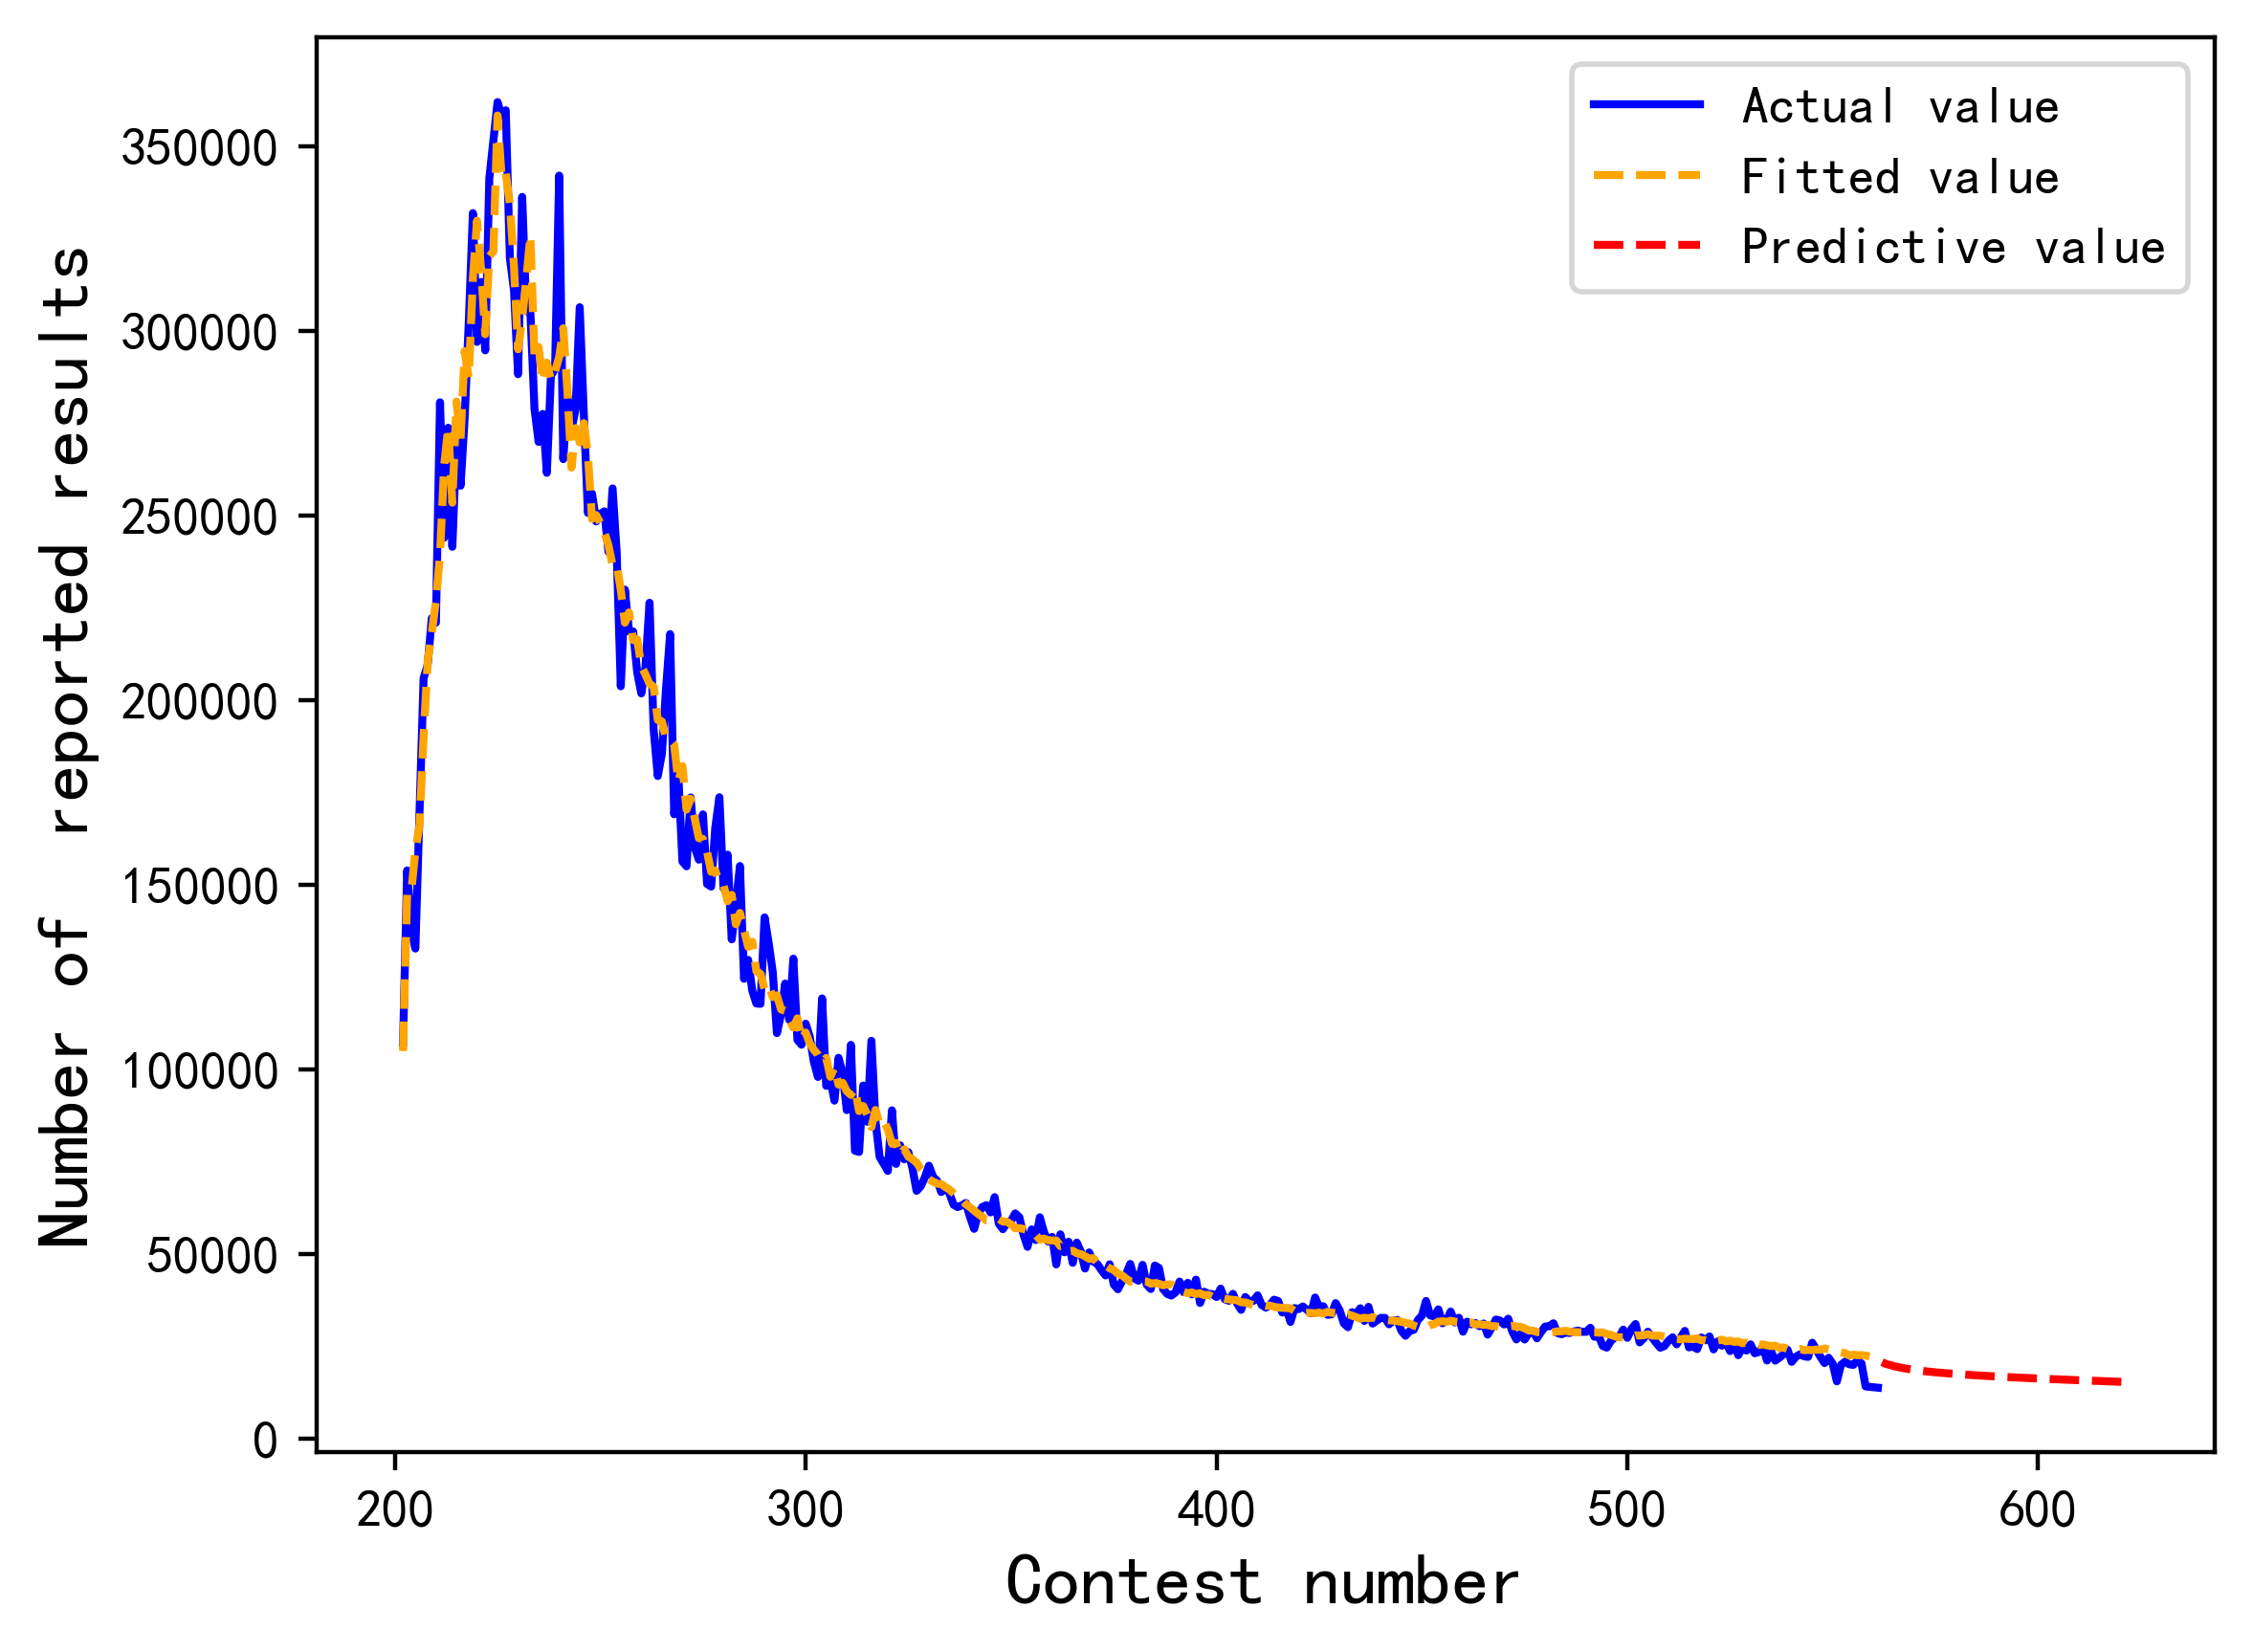

In [27]:
nTrain = int(dataY.shape[0] * rate)  # 拟合的数量
nData = dataY.shape[0]  # 预测的数量

# 绘制对比图
plt.rcParams['font.sans-serif'] = 'KaiTi'  # 正常显示中文
fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)
ax.plot(np.arange(202, 202+360), dataY[:360], color='blue', label="Actual value")
ax.plot(np.arange(202, 202+360), dataP[:360], color='orange', \
        linestyle='--', label='Fitted value')
ax.plot(np.arange(202+360, 202+nData), dataP[360:], \
        linestyle='--', color='red', label='Predictive value')
ax.legend()
plt.xlabel('Contest number',fontsize=14)
plt.ylabel('Number of  reported results',fontsize=14)

fig.savefig('test.png', dpi=400)

In [28]:
dataY.shape

(421,)

In [29]:
dataP[-1]

15356.175926864147

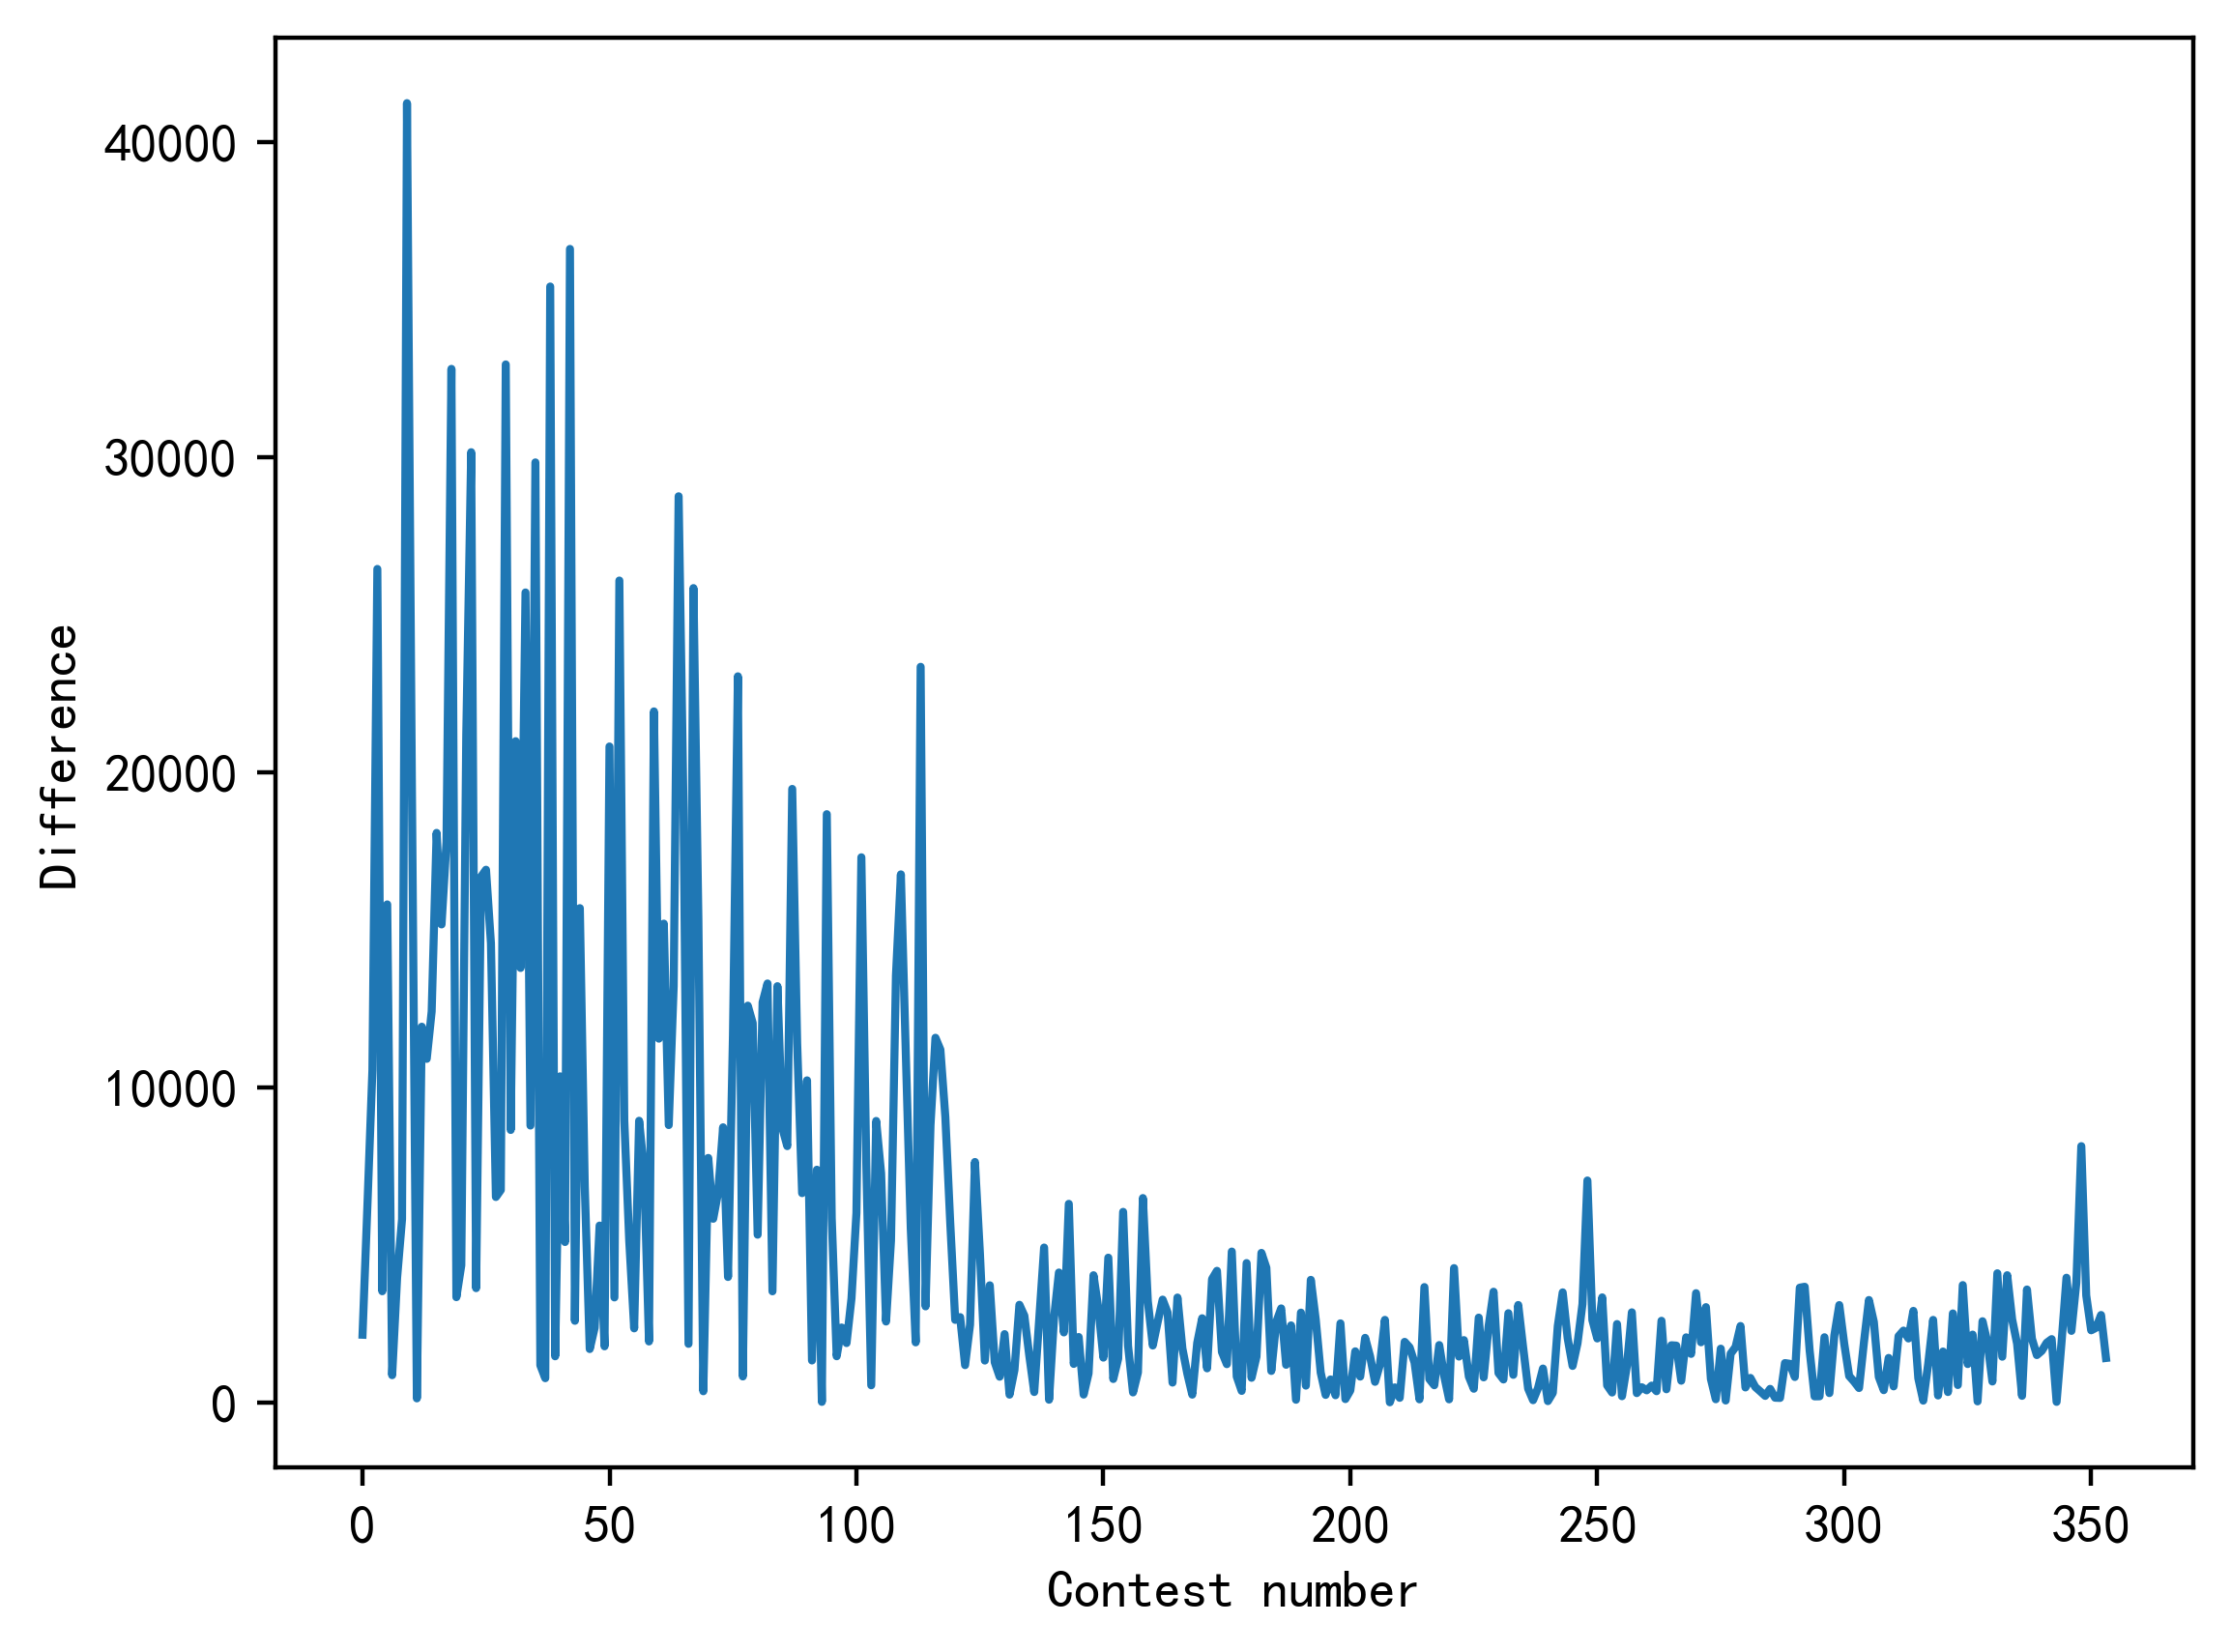

In [30]:
# 计算dataY和dataP的差值，取绝对值并绘制图像
diff = np.abs(dataY[:355] - dataP[:355])
# 去掉一个最大值
diff = np.delete(diff, np.argmax(diff))
fig = plt.figure(dpi=400)
plt.plot(diff)
plt.xlabel('Contest number')
plt.ylabel('Difference')
fig.savefig('diff.png', dpi=400)
